# RRT (Rapidly-exploring Random Tree) and Bidirectional-RRT # 

In [1]:
import random
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import imageio
import io
import numpy as np
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.geometry import Point
from shapely.geometry import Point as ShapelyPoint
from shapely.geometry import LineString

In [2]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y 
        self.parent = None

The Node class represents the nodes in the tree. Each node has an attribute to store the position (x, y) in the space and an attribute for the parent node.

In [3]:
def draw_background():
    plt.figure(figsize=(10, 8))
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Robot Motion Planning: RRT')
    plt.grid(False)

def generate_random_polygon_obstacle(num_vertices_range, x_range, y_range):
    num_vertices = np.random.randint(*num_vertices_range) # unpacking
    vertices = np.random.rand(num_vertices, 2) * [x_range, y_range]
    obstacle = Polygon(vertices, closed=True, edgecolor='black', facecolor='gray')
    return obstacle

def draw_polygon_obstacles(obstacles):
    for obstacle in obstacles:
        polygon = Polygon(obstacle.get_xy(), closed=True, edgecolor='black', facecolor='gray')
        plt.gca().add_patch(polygon)

__*draw_background()*__ : Creates a new plot with specific dimensions (10 inches by 8 inches), sets the X and Y axis limits to range from 0 to 100, labels the X and Y axes. 

__*generate_random_polygon_obstacle(num_vertices_range, x_range, y_range)*__ : Generates a random polygon obstacle with a random number of vertices within a specified range (num_vertices_range) and random coordinates within specified ranges (x_range and y_range). Each vertex is generated with random coordinates and used to create a polygon obstacle with specified characteristics (closed shape, black border, gray face). 

__*draw_polygon_obstacles(obstacles)*__ : Draws a collection of polygon obstacles onto the current plot. It iterates over each obstacle in the obstacles list and adds each one as a patch to the current plot.

In [4]:
def generate_random_point(min_xy, max_xy):
    x = random.uniform(min_xy, max_xy)
    y = random.uniform(min_xy, max_xy)
    return Point(x, y)

def distance(node_x, node_y, point_x, point_y):
    return math.sqrt((node_x - point_x)**2 + (node_y - point_y)**2)

def find_nearest_node(tree, random_point_x, random_point_y):
    min_dist = math.inf
    nearest_node = None
    for node in tree:
        dist = distance(node.x, node.y, random_point_x, random_point_y)
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    return nearest_node

__*def generate_random_point(min_x, max_x, min_y, max_y)*__ : Generates a random point in the space. 

__*def distance(x, y)*__ : Calculates the distance between two positions. 

__*def find_nearest_node(tree, random_point)*__ : Given a point find the nearest node in the tree. 

In [5]:
def is_collision_free(point, obstacles):
    point_shapely = ShapelyPoint(point.x, point.y)
    for obstacle in obstacles:
        obstacle_shapely = ShapelyPolygon(obstacle.get_xy())
        if obstacle_shapely.contains(point_shapely):
            return False
    return True

def is_path_collision_free(start_point, end_point, obstacles):
    path_line = LineString([(start_point.x, start_point.y), (end_point.x, end_point.y)])
    for obstacle in obstacles:
        obstacle_polygon = ShapelyPolygon(obstacle.get_xy())
        if path_line.intersects(obstacle_polygon):
            return False
    return True

__*def is_collision_free(point, obstacles)*__ : This function checks whether given a point does not overlap with any of the obstacles in the environment.

__*def is_path_collision_free(start_point, end_point, obstacles)*__ : This function checks whether a straight line (or segment) between two points does not cross any of the obstacles in the environment.

In both functions, the Shapely module is used to represent points and polygons and to perform geometric operations such as containment and intersection checking. Obstacles are represented as polygons, while the path is represented as a straight line between two points.

In [6]:
def choose_new_point(random_point, nearest_node, obstacles):
    # Calculate the length of the segment.
    dist_x = abs (random_point.x - nearest_node.x)
    dist_y = abs (random_point.y -nearest_node.y)
    length_segment = max (dist_x, dist_y)
    dist_max = []
    # Generates points along the segment.
    points = []
    for i in range(int(length_segment) + 1):
        x = round(random_point.x + (i / length_segment) * (nearest_node.x - random_point.x))
        y = round(random_point.y + (i / length_segment) * (nearest_node.y - random_point.y))
        points.append((x, y)) 
    for p in points:
        dist = distance(nearest_node.x, nearest_node.y, p[0] , p[1])
        dist_max.append((dist, p))
    dist_max = sorted(dist_max, key=lambda x: x[0], reverse=True)
    for i in dist_max:
            if is_path_collision_free(Point(i[1][0], i[1][1]), nearest_node, obstacles):
                return i[1]
        
def add_node_to_tree(new_node, parent_node):
    new_node.parent = parent_node

def extend_tree(tree, qnew):
    tree.append(qnew)      

__*def choose_new_point(random_point, nearest_node, obstacles)*__ : This function chooses a new point along the segment between the random point and the nearest node. It calculates the length of the segment using the difference between the x and y coordinates of the random point and the nearest node, then determines the maximum length between these two differences.It generates a series of points along the segment using the linear interpolation formula.
For each point generated along the segment, calculate the distance between the point and the nearest node.

__*def add_node_to_tree(new_node, nearest_node)*__ : This function adds the newly created node (arising from the chosen point) as a child of the nearest node.

__*def extend_tree(tree, qnew)*__ : This function extends the tree by adding the new node to it.

In [7]:
def rrt(num_iterations, obstacles, start_point, goal_point):
    tree = []
    tree_list = []
    tree = [Node(start_point.x, start_point.y)]
    tree_list = [tree.copy()]

    for i in range(num_iterations):  
        if i % 100 != 0:
            random_point = generate_random_point(0, 100)
            nearest_node = find_nearest_node(tree, random_point.x, random_point.y)
            qs = choose_new_point(random_point, nearest_node, obstacles)
            if qs is not None:
                new_node = Node(qs[0], qs[1])
                add_node_to_tree(new_node, nearest_node)
                extend_tree(tree, new_node)
        else:
            qs = (goal_point.x, goal_point.y)  
            nearest_node = find_nearest_node(tree, qs[0], qs[1])
            if is_path_collision_free(goal_point, nearest_node, obstacles):
                goal_node = Node(goal_point.x, goal_point.y)
                add_node_to_tree(goal_node, nearest_node)
                extend_tree(tree, goal_node)
                tree_list.append(tree.copy())  
                return tree_list

        tree_list.append(tree.copy())  
    return tree_list

__*def rrt(num_iterations, obstacles, start_point, goal_point)*__ : This function implements the RRT (Rapidly-exploring Random Tree) algorithm to find paths in a configuration space.
An empty tree is initialized as well as a list that will contain the states of the tree at each iteration.
The starting point is added as an initial node to the tree.
A loop is executed for a specified number of iterations (num_iterations).
At each iteration, a random point in the environment is generated.
The tree node closest to the generated random point is found.
A new point is chosen along the segment between the random point and the nearest node, avoiding collisions with obstacles.
If the new point does not cause collisions, it is added to the tree as a new node.
The new node is extended in the tree.
Every 100 iterations it is checked whether the goal_point can be added to the tree, i.e., whether there is a collision-free path between the goal_point and the nearest_node, if so the algorithm terminates by returning the tree.
If the maximum number of iterations is reached without the target point being reached, the algorithm still returns the current tree.


In [8]:
def get_path_to_root(node):
    path = []
    while node is not None:
        path.append(node)
        node = node.parent
    return list(reversed(path))  # Invert the list to get the path from the root to the current node

def check_intersection(tree_start, tree_goal, obstacles):
    for node_start in tree_start:
        for node_goal in tree_goal:
            if is_path_collision_free(node_start, node_goal, obstacles):
                return (node_start, node_goal)
    return None

def rrt_bidirectional(num_iterations, obstacles, start_point, goal_point, threshold_distance=2.0):
    tree_start = [Node(start_point.x, start_point.y)]
    tree_goal = [Node(goal_point.x, goal_point.y)]
    final_path = None
    rrt_trees = []

    for iteration in range(num_iterations):
        random_point_start = generate_random_point(0, 100)
        nearest_node_start = find_nearest_node(tree_start, random_point_start.x, random_point_start.y)
        qs_start = choose_new_point(random_point_start, nearest_node_start, obstacles)
        if qs_start is not None:
            new_node_start = Node(qs_start[0], qs_start[1])
            add_node_to_tree(new_node_start, nearest_node_start)
            extend_tree(tree_start, new_node_start)

        random_point_goal = generate_random_point(0, 100)
        nearest_node_goal = find_nearest_node(tree_goal, random_point_goal.x, random_point_goal.y)
        qs_goal = choose_new_point(random_point_goal, nearest_node_goal, obstacles)
        if qs_goal is not None:
            new_node_goal = Node(qs_goal[0], qs_goal[1])
            add_node_to_tree(new_node_goal, nearest_node_goal)
            extend_tree(tree_goal, new_node_goal)

        if iteration % 50 == 0:
            latest_nodes_goal = tree_goal[-1]
            nearest_node = find_nearest_node(tree_start, latest_nodes_goal.x, latest_nodes_goal.y) 
            if is_path_collision_free(latest_nodes_goal, nearest_node, obstacles):
                path_start = get_path_to_root(nearest_node)
                path_goal = get_path_to_root(latest_nodes_goal)
                path_goal.reverse()
                final_path = path_start + path_goal
                return final_path, rrt_trees

        if iteration % 1 == 0:
            rrt_trees.append((tree_start.copy(), tree_goal.copy()))

    return final_path, rrt_trees



__*get_path_to_root(node)*__ : This function returns the path from the root of a tree to the specified node. It is used to obtain the path from the root to the current node.

__*check_intersection(tree_start, tree_goal, obstacles)*__ : This function checks whether there is an intersection between the two trees (source tree and target tree). It scans pairs of nodes from the two trees and checks whether the path between them is free of collisions with obstacles.

__*rrt_bidirectional(num_iterations, obstacles, start_point, goal_point, threshold_distance=2.0)*__ : Implements the bidirectional RRT algorithm to find a path between a starting point and a destination point.
It uses two RRT trees, one for the starting point and one for the destination point, and attempts to extend them to the opposite point. Every tot iterations, it checks whether the newest node in the destination point tree can be joined to the nearest node in the start point tree without collision. If it finds a valid path, it returns the final path and a list of RRT tree pairs for each iteration.

These functions form a basic implementation of the bidirectional RRT algorithm for path planning.

**Execution of the RRT algorithm**:

Iteration 1/302
Iteration 2/302
Iteration 3/302


/tmp/ipykernel_19616/1451141092.py:81: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)


Iteration 4/302
Iteration 5/302
Iteration 6/302
Iteration 7/302
Iteration 8/302
Iteration 9/302
Iteration 10/302
Iteration 11/302
Iteration 12/302
Iteration 13/302
Iteration 14/302
Iteration 15/302
Iteration 16/302
Iteration 17/302
Iteration 18/302
Iteration 19/302
Iteration 20/302


/tmp/ipykernel_19616/2647180751.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))
/tmp/ipykernel_19616/1451141092.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))


Iteration 21/302
Iteration 22/302
Iteration 23/302
Iteration 24/302
Iteration 25/302
Iteration 26/302
Iteration 27/302
Iteration 28/302
Iteration 29/302
Iteration 30/302
Iteration 31/302
Iteration 32/302
Iteration 33/302
Iteration 34/302
Iteration 35/302
Iteration 36/302
Iteration 37/302
Iteration 38/302
Iteration 39/302
Iteration 40/302
Iteration 41/302
Iteration 42/302
Iteration 43/302
Iteration 44/302
Iteration 45/302
Iteration 46/302
Iteration 47/302
Iteration 48/302
Iteration 49/302
Iteration 50/302
Iteration 51/302
Iteration 52/302
Iteration 53/302
Iteration 54/302
Iteration 55/302
Iteration 56/302
Iteration 57/302
Iteration 58/302
Iteration 59/302
Iteration 60/302
Iteration 61/302
Iteration 62/302
Iteration 63/302
Iteration 64/302
Iteration 65/302
Iteration 66/302
Iteration 67/302
Iteration 68/302
Iteration 69/302
Iteration 70/302
Iteration 71/302
Iteration 72/302
Iteration 73/302
Iteration 74/302
Iteration 75/302
Iteration 76/302
Iteration 77/302
Iteration 78/302
Iteration 79/3

/tmp/ipykernel_19616/1451141092.py:103: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)


GIF created: rrt_animation.gif


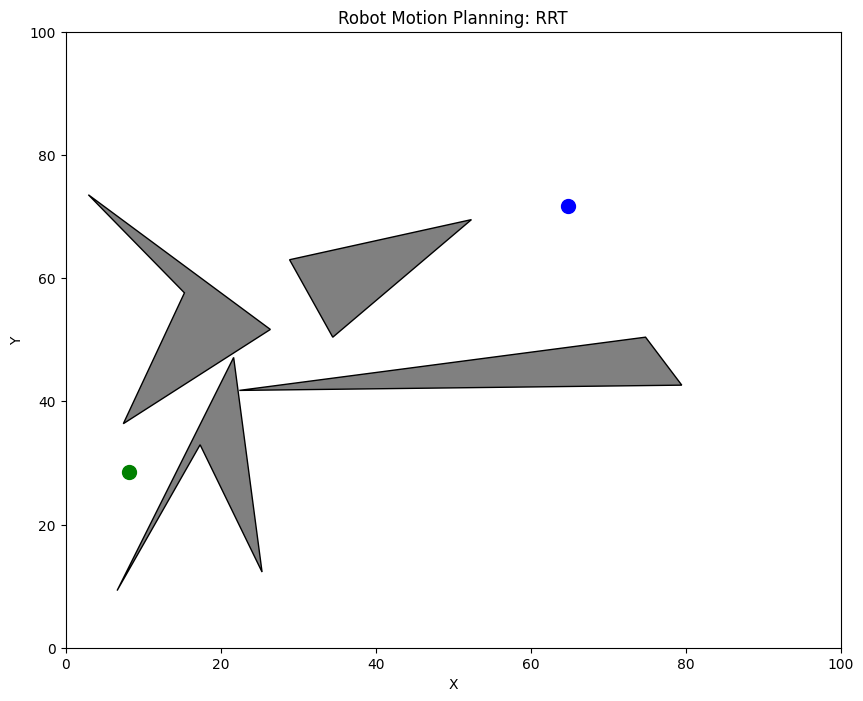

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [9]:
custom_light_green = (0.4, 0.6, 0.4)  
custom_light_blue = (0.4, 0.4, 0.6) 

x_range = (0, 100)
y_range = (0, 100)
# will generate a random number between 3 and 5, inclusive.
num_obstacles = np.random.randint(3, 6) 
obstacles = []
image_files = []

iteration = 0
while iteration < num_obstacles:
    x_range = np.random.randint(30, 100)
    y_range = np.random.randint(60, 100)
    obstacle = generate_random_polygon_obstacle((3, 5), x_range, y_range)

# checking for possible collisions
    overlapping = False
    obstacle_shapely = ShapelyPolygon(obstacle.get_xy())
    for prev_obstacle in obstacles: 
        prev_obstacle_shapely = ShapelyPolygon(prev_obstacle.get_xy())
        if obstacle_shapely.intersects(prev_obstacle_shapely):
            overlapping = True
            break
    if not overlapping:
        obstacles.append(obstacle)
        iteration += 1

draw_background()
draw_polygon_obstacles(obstacles)


s = False
g = False

while s == False:
    start_point = generate_random_point(0, 35) 
    if is_collision_free(start_point, obstacles):
        plt.plot(start_point.x, start_point.y, marker='o', markersize=10, color= "green", label='Start')
        s = True
        break  

while g == False:
    goal_point = generate_random_point(60, 100) 
    if is_collision_free(goal_point, obstacles):
        plt.plot(goal_point.x, goal_point.y, marker='o', markersize=10, color= "blue", label='Goal')
        g = True
        break  

# Eexecution of the RRT algorithm
rrt_trees = rrt(1000, obstacles, start_point, goal_point)

# Find the final path
final_path = []
current_node = rrt_trees[-1][-1]  # Last node of the last RRT tree
while current_node:
    final_path.append((current_node.x, current_node.y))
    current_node = current_node.parent



gif_filename = 'rrt_animation.gif'
with imageio.get_writer(gif_filename, mode='I') as writer:
    for i, tree in enumerate(rrt_trees):
        print(f"Iteration {i+1}/{len(rrt_trees)}")  # Print the current iteration number
        
        plt.figure(figsize=(10, 8))
        draw_background()
        draw_polygon_obstacles(obstacles)
        for node in tree:
            if node.parent:
                plt.plot([node.x, node.parent.x], [node.y, node.parent.y], color=custom_light_green, linewidth=3)
        plt.plot(start_point.x, start_point.y, marker='o', markersize=10, color="green", label='Start')
        plt.plot(goal_point.x, goal_point.y, marker='o', markersize=10, color="blue", label='Goal')
        plt.legend()
        plt.title(f'RRT Iteration {i+1}')
        
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = imageio.imread(buf)
        writer.append_data(image)
        
        plt.close()  

    if final_path:
        plt.figure(figsize=(10, 8))
        draw_background()
        draw_polygon_obstacles(obstacles)
        for node in tree:
            if node.parent:
                plt.plot([node.x, node.parent.x], [node.y, node.parent.y], color=custom_light_green, linewidth=3)
        plt.plot(start_point.x, start_point.y, marker='o', markersize=10, color="green", label='Start')
        plt.plot(goal_point.x, goal_point.y, marker='o', markersize=10, color="blue", label='Goal')
        path_x, path_y = zip(*final_path)
        plt.plot(path_x, path_y, color='red', linewidth=4, alpha=0.7, label='Final Path')
        plt.legend()
        plt.title(f'Final Path: Iteration {i+1}')
        
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = imageio.imread(buf)
        writer.append_data(image)
        
        plt.close() 



print(f"GIF created: {gif_filename}")

__*Obstacle generation:*__

Initially, the x- and y-axis range (x_range and y_range) are defined and a random number of obstacles between 3 and 5 (inclusive) are generated.
A loop is run until all desired obstacles are generated, ensuring that they do not overlap with previous obstacles.
The obstacles are represented as randomly generated polygons using the generate_random_polygon_obstacle function.

__*Generation of start_point and goal_point:*__

A start point (start_point) and destination point (goal_point) are randomly generated, ensuring that both do not overlap with obstacles.

__*Execution of the RRT algorithm:*__

The RRT function is called, which takes as input the desired number of iterations, obstacles, starting point and destination point.
The RRT algorithm is executed for a specified number of iterations, adding nodes to the RRT tree in order to explore the search space. An animated GIF file is created to visualize the evolution of the RRT algorithm during iterations.

/tmp/ipykernel_19616/3923774873.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)
/tmp/ipykernel_19616/3923774873.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)


Iteration 1/100
Iteration 2/100
Iteration 3/100
Iteration 4/100
Iteration 5/100
Iteration 6/100
Iteration 7/100
Iteration 8/100
Iteration 9/100
Iteration 10/100
Iteration 11/100
Iteration 12/100
Iteration 13/100
Iteration 14/100
Iteration 15/100
Iteration 16/100
Iteration 17/100
Iteration 18/100
Iteration 19/100
Iteration 20/100


/tmp/ipykernel_19616/2647180751.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))
/tmp/ipykernel_19616/3923774873.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))


Iteration 21/100
Iteration 22/100
Iteration 23/100
Iteration 24/100
Iteration 25/100
Iteration 26/100
Iteration 27/100
Iteration 28/100
Iteration 29/100
Iteration 30/100
Iteration 31/100
Iteration 32/100
Iteration 33/100
Iteration 34/100
Iteration 35/100
Iteration 36/100
Iteration 37/100
Iteration 38/100
Iteration 39/100
Iteration 40/100
Iteration 41/100
Iteration 42/100
Iteration 43/100
Iteration 44/100
Iteration 45/100
Iteration 46/100
Iteration 47/100
Iteration 48/100
Iteration 49/100
Iteration 50/100
Iteration 51/100
Iteration 52/100
Iteration 53/100
Iteration 54/100
Iteration 55/100
Iteration 56/100
Iteration 57/100
Iteration 58/100
Iteration 59/100
Iteration 60/100
Iteration 61/100
Iteration 62/100
Iteration 63/100
Iteration 64/100
Iteration 65/100
Iteration 66/100
Iteration 67/100
Iteration 68/100
Iteration 69/100
Iteration 70/100
Iteration 71/100
Iteration 72/100
Iteration 73/100
Iteration 74/100
Iteration 75/100
Iteration 76/100
Iteration 77/100
Iteration 78/100
Iteration 79/1

<Figure size 1000x800 with 0 Axes>

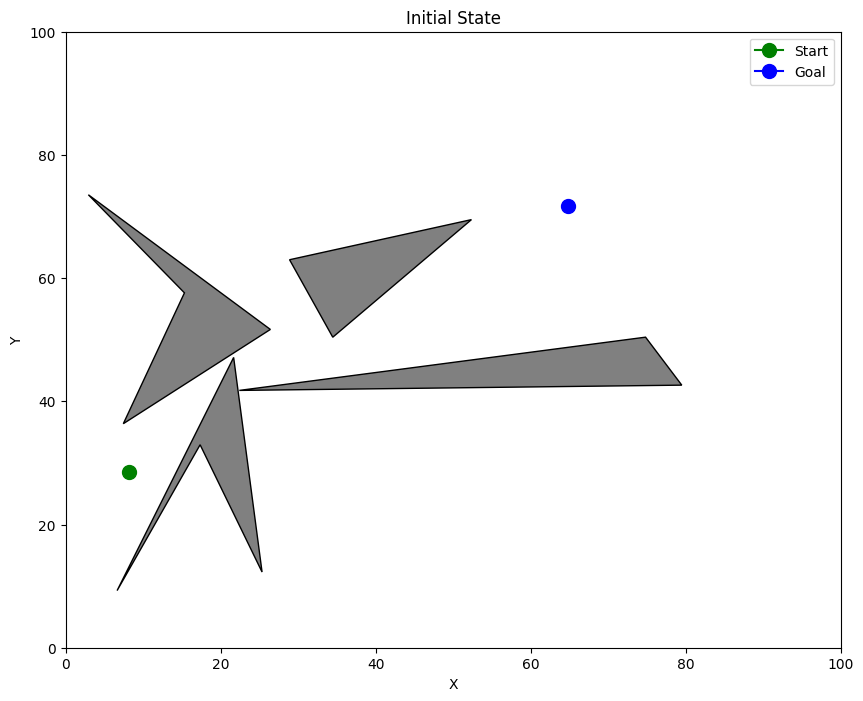

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [15]:
# Execution of the RRT bidirectional algorithm
final_path, rrt_trees = rrt_bidirectional(1000, obstacles, start_point, goal_point)

# Create gif
gif_filename = 'rrt_bidirectional_animation.gif'

# Create gif frames
with imageio.get_writer(gif_filename, mode='I') as writer:
    # Draw initial background without any paths
    plt.figure(figsize=(10, 8))
    draw_background()
    draw_polygon_obstacles(obstacles)
    plt.plot(start_point.x, start_point.y, marker='o', markersize=10, color='green', label='Start')
    plt.plot(goal_point.x, goal_point.y, marker='o', markersize=10, color='blue', label='Goal')
    plt.legend()
    plt.title('Initial State')
    
    # Save initial frame
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = imageio.imread(buf)
    writer.append_data(image)

    # Create gif frames for each iteration
    for i, (tree_start, tree_goal) in enumerate(rrt_trees):
        print(f"Iteration {i+1}/{len(rrt_trees)}")  # Print the current iteration number
        plt.figure(figsize=(10, 8))
        draw_background()
        draw_polygon_obstacles(obstacles)
        for node_start in tree_start:
            if node_start.parent:
                plt.plot([node_start.x, node_start.parent.x], [node_start.y, node_start.parent.y], color=custom_light_green, linewidth=3)
        for node_goal in tree_goal:
            if node_goal.parent:
                plt.plot([node_goal.x, node_goal.parent.x], [node_goal.y, node_goal.parent.y],  color=custom_light_blue, linewidth=3)
        plt.plot(start_point.x, start_point.y, marker='o', markersize=10, color='green', label='Start')
        plt.plot(goal_point.x, goal_point.y, marker='o', markersize=10, color='blue', label='Goal')
        
        # Trace the final route in red if it exists
        if i == len(rrt_trees) - 1 and final_path:
            for node_start, node_goal in zip(final_path[:-1], final_path[1:]):
                plt.plot([node_start.x, node_goal.x], [node_start.y, node_goal.y], color='red', linewidth=4, alpha=1.0)
        
        plt.legend()
        plt.title(f'RRT Bidirectional Iteration {i+1}')
        
        # Get the bytes of the image data
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = imageio.imread(buf)
        writer.append_data(image)
        
        plt.close()  

print(f"GIF created: {gif_filename}")

__*Execution of the RRT_bidirectional algorithm:*__

This code block executes the bidirectional RRT algorithm to find an optimal path between a starting point and an ending point, taking into account obstacles in the environment. The algorithm generates a series of frames showing the evolution of the RRT trees created during execution, along with the final path found. Initially, the algorithm performs *num_iterations* iterations of the bidirectional RRT, adding nodes to the RRT trees starting from the starting point and ending point. At each iteration, it checks whether the last nodes added to the trees are sufficiently close to each other. If yes, a final path is constructed by combining the paths from the root trees to the neighboring nodes.
Next, frames are created for the GIF showing the evolution of the RRT trees over time. These frames are generated using imageio to create the animated GIF. Each frame shows the current state of the RRT trees, with the nodes represented as points in the graph and the paths between nodes represented by lines.

In [11]:
import imageio

def extract_frames(input_path, output_path):
    # Ottieni un oggetto reader per il file GIF
    reader = imageio.get_reader(input_path)

    # Estrai il primo frame
    first_frame = reader.get_data(0)

    # Estrai l'ultimo frame
    num_frames = len(reader)
    last_frame = reader.get_data(num_frames - 1)

    # Salva i frame come immagini PNG
    imageio.imwrite(output_path + "_first_frame.png", first_frame)
    imageio.imwrite(output_path + "_last_frame.png", last_frame)

# Specifica il percorso del file GIF di input e il percorso di output per le immagini PNG
input_gif_path = "rrt_bidirectional_animation.gif"
output_png_path = "rrt_b"
input2_gif_path = "rrt_animation.gif"
outpu2t_png_path = "rrt_"

# Chiama la funzione per estrarre i frame
extract_frames(input_gif_path, output_png_path)
extract_frames(input2_gif_path, outpu2t_png_path)


In [12]:
from PIL import Image

# Carica la GIF
gif_path = "rrt_animation.gif"
gif_reader = imageio.get_reader(gif_path)

# Carica il PNG
png_path = "rrt_b_first_frame.png"
png_image = Image.open(png_path)

# Prendi le dimensioni del primo frame della GIF e del PNG
gif_frame = Image.fromarray(gif_reader.get_data(0))
gif_width, gif_height = gif_frame.size
png_width, png_height = png_image.size

# Crea una lista per i frame finali
final_frames = []

# Sovrapponi il PNG su ciascun frame della GIF
for frame in gif_reader:
    # Converte il frame della GIF in un'immagine PIL
    gif_frame = Image.fromarray(frame)

    # Crea un'immagine vuota per il frame finale
    final_frame = Image.new("RGBA", (gif_width + png_width, max(gif_height, png_height)))

    # Aggiungi il frame della GIF a sinistra
    final_frame.paste(gif_frame, (0, 0))

    # Aggiungi il PNG a destra
    final_frame.paste(png_image, (gif_width, 0))

    # Aggiungi l'immagine finale alla lista dei frame finali
    final_frames.append(final_frame)

# Salva l'animazione finale come GIF
output_path = "final_animation.gif"
final_frames[0].save(output_path, save_all=True, append_images=final_frames[1:], loop=0, duration=gif_reader.get_meta_data()['duration'])


In [13]:
from PIL import Image

# Carica la GIF
gif_path = "rrt_bidirectional_animation.gif"
gif_reader = imageio.get_reader(gif_path)

# Carica il PNG
png_path = "rrt__last_frame.png"
png_image = Image.open(png_path)

# Prendi le dimensioni del primo frame della GIF e del PNG
gif_frame = Image.fromarray(gif_reader.get_data(0))
gif_width, gif_height = gif_frame.size
png_width, png_height = png_image.size

# Crea una lista per i frame finali
final_frames = []

# Sovrapponi il PNG su ciascun frame della GIF
for frame in gif_reader:
    # Converte il frame della GIF in un'immagine PIL
    gif_frame = Image.fromarray(frame)

    # Crea un'immagine vuota per il frame finale
    final_frame = Image.new("RGBA", (gif_width + png_width, max(gif_height, png_height)))

    # Aggiungi il PNG a sinistra
    final_frame.paste(png_image, (0, 0))

    # Aggiungi il frame della GIF a destra
    final_frame.paste(gif_frame, (png_width, 0))

    # Aggiungi l'immagine finale alla lista dei frame finali
    final_frames.append(final_frame)

# Aggiungi alcuni frame vuoti per far durare l'ultimo frame della GIF
num_empty_frames = 200
last_frame = final_frames[-1]
for _ in range(num_empty_frames):
    final_frames.append(last_frame.copy())

# Salva l'animazione finale come GIF
output_path = "final_animationbiderectional.gif"
final_frames[0].save(output_path, save_all=True, append_images=final_frames[1:], loop=0, duration=gif_reader.get_meta_data()['duration'] + num_empty_frames)
